# ML in Cybersecurity: Project II

## Team
  * **Team name**:  The Hidden Adversaries
  * **Members**:  Tomas Amado (toam00001@stud.uni-saarland.de), Deepanshu Mehta (deme00001@stud.uni-saarland.de), Marco Schuster (masc00008@stud.uni-saarland.de)
  * **Tutor**: *fill this in*


## Logistics
  * **Due date**: 14th December 2020, 13:59:59 
  * Email the completed notebook to mlcysec_ws2021_staff@lists.cispa.saarland 
  * Complete this in the previously established **teams of 3**
  * Feel free to use the course [mailing list](https://lists.cispa.saarland/listinfo/mlcysec_ws2021_stud) to discuss.
  
## Timeline
  * 30-Nov-2020: Project 2 hand-out
  * **14-Dec-2020** (13:59:59): Email completed notebook to mlcysec_ws2021_staff@lists.cispa.saarland

  
  
## About this Project
In this project, we dive into the vulnerabilities of machine learning models and the difficulties of defending against them. To this end, we require you to implement an evasion attack (craft adversarial examples) yourselves, and defend your own model.   


## A Note on Grading
The total number of points in this project is 100. We further provide the number of points achievable with each excercise. You should take particular care to document and visualize your results, though.


 
## Filling-in the Notebook
You'll be submitting this very notebook that is filled-in with (all!) your code and analysis. Make sure you submit one that has been previously executed in-order. (So that results/graphs are already visible upon opening it). 

The notebook you submit **should compile** (or should be self-contained and sufficiently commented). Check tutorial 1 on how to set up the Python3 environment.

It is extremely important that you **do not** re-order the existing sections. Apart from that, the code blocks that you need to fill-in are given by:
```
#
#
# ------- Your Code -------
#
#
```
Feel free to break this into multiple-cells. It's even better if you interleave explanations and code-blocks so that the entire notebook forms a readable "story".


## Code of Honor
We encourage discussing ideas and concepts with other students to help you learn and better understand the course content. However, the work you submit and present **must be original** and demonstrate your effort in solving the presented problems. **We will not tolerate** blatantly using existing solutions (such as from the internet), improper collaboration (e.g., sharing code or experimental data between groups) and plagiarism. If the honor code is not met, no points will be awarded.

 
 ## Versions
  * v1.0: Initial notebook
  * v1.1: Clarifications at 1.1.2, 1.2.2, 2.1
 
  ---

In [1]:
import time 
 
import numpy as np 
import matplotlib.pyplot as plt 

import json 
import time 
import pickle 
import sys 
import csv 
import os 
import os.path as osp 
import shutil 

import pandas as pd

from IPython.display import display, HTML
 
%matplotlib inline 
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots 
plt.rcParams['image.interpolation'] = 'nearest' 
plt.rcParams['image.cmap'] = 'gray' 
 
# for auto-reloading external modules 
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython 
%load_ext autoreload
%autoreload 2

In [2]:
# Some suggestions of our libraries that might be helpful for this project
from collections import Counter          # an even easier way to count
from multiprocessing import Pool         # for multiprocessing
from tqdm import tqdm                    # fancy progress bars

# Load other libraries here.
# Keep it minimal! We should be easily able to reproduce your code.
# We only support sklearn and pytorch.
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data

# We preload pytorch as an example
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset

In [3]:
compute_mode = 'cpu'

if compute_mode == 'cpu':
    device = torch.device('cpu')
elif compute_mode == 'gpu':
    # If you are using pytorch on the GPU cluster, you have to manually specify which GPU device to use
    # It is extremely important that you *do not* spawn multi-GPU jobs.
    os.environ["CUDA_VISIBLE_DEVICES"] = '0'    # Set device ID here
    device = torch.device('cuda')
else:
    raise ValueError('Unrecognized compute mode')

#### Helpers

In case you choose to have some methods you plan to reuse during the notebook, define them here. This will avoid clutter and keep rest of the notebook succinct.

In [4]:
# get indices of first samples that match a desired label
def getFirstPositionOfEachLabel(y, allLabels):
    result = []
    for i in allLabels:
        labelPositions = np.argwhere(y.numpy() == i)
        result.append(labelPositions[0][0].item())
    return result

def identity_func(foo):
    return foo

# wraps a separated dataset to avoid issues while shuffling
class WrapperDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.y)

# get the same batch split for inputs and labels
def get_batched_x_y(x, y, batch_size, shuffle):
    dataset = WrapperDataset(x, y)
    batched = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return batched

# You can use this function to flatten 2D inputs
def flatten_input_pixels(x_input):
    result = []
    for i in range(len(x_input)):
        result.append(x_input[i].flatten())
    return np.array(result, np.uint8)  # [n_samples, n_features]


# 1. Attacking an ML-model

In this section, we implement an attack ourselves. We then leverage the Foolbox library to craft adversarial examples. First, however, you need a model you can attack. Feel free to choose the DNN/ConvNN from project 1.

Hint: you might want to save the trained model to save time later.

### 1.1.1: Setting up the model (5 Points)

Re-use the model from project 1 here and train it until it achieves reasonable accuracy (>92%).

In [5]:
# (1)load data 
# (2)define model
# (3)define loss, optimizer 
# (4)train (You can re-use the trained model from project1)
# (5)evaluate

Same data loading as in Project 1. However, for the CNN we only need the non-flattened dataset. Thus, x is now three dimensional.

In [6]:
# load the training set
training_set = datasets.MNIST(root="", train=True, download=True)
x_trainval = training_set.data
y_trainval = training_set.targets
# load the test set
test_set = datasets.MNIST(root="", train=False, download=True)
x_test = test_set.data
y_test = test_set.targets

print('x_trainval.shape = {},  y_trainval.shape = {}'.format(x_trainval.shape, y_trainval.shape))
print('x_test.shape = {},  y_test.shape = {}'.format(x_test.shape, y_test.shape))

x_trainval.shape = torch.Size([60000, 28, 28]),  y_trainval.shape = torch.Size([60000])
x_test.shape = torch.Size([10000, 28, 28]),  y_test.shape = torch.Size([10000])


Like in Project 1 we next set the seed.

In [7]:
# Please set random seed to have reproduceable results, e.g. torch.manual_seed(123)
_ = np.random.seed(42)
_ = torch.manual_seed(42)

We also use the same normalization on the input images.

In [8]:
# normalize inputs to interval [0, 1]
x_trainval = x_trainval / torch.max(x_trainval)
x_test = x_test / torch.max(x_test)

print("x_trainval: min", torch.min(x_trainval), "max", torch.max(x_trainval))
print("x_test: min", torch.min(x_test), "max", torch.max(x_test))

x_trainval: min tensor(0.) max tensor(1.)
x_test: min tensor(0.) max tensor(1.)


Now, we can define our model as in Project 1 and load its trained parameters.

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, (3,3))
        self.pool1 = nn.MaxPool2d((2,2))
        self.conv2 = nn.Conv2d(16, 16, (3,3))
        self.pool2 = nn.MaxPool2d((2,2))
        self.linear1 = nn.Linear(400, 64)
        self.linear2 = nn.Linear(64, 10)

    def forward(self, x):
        relu = nn.ReLU()
        softmax = nn.Softmax(dim=1)
        result = relu(self.conv1(x))
        result = self.pool1(result)

        result = relu(self.conv2(result))
        result = self.pool2(result)

        # flatten convolutional output
        result = result.view(-1, 400)

        result = relu(self.linear1(result))
        result = softmax(self.linear2(result))

        return result

In [10]:
model = Net()
# load model to selected device
model.load_state_dict(torch.load("model.pt", map_location=device))

<All keys matched successfully>

Finally, we can evaluate the model on the test set.

In [11]:
def getModelOutput(x, model):
    # add channel dimension
    myX = torch.unsqueeze(x, 1)
    # move data to GPU
    myX = myX.to(device)
    # get CNN output
    output = model(myX)
    return output

def predict(x, model):
    output = getModelOutput(x, model)
    # extract predictions as largest activation
    predictions = torch.argmax(output, 1)
    return predictions

In [12]:
predictions = predict(x_test, model)
testAccuracy = torch.sum(predictions == y_test) / len(y_test)
print("Test accuracy of model is", testAccuracy.item() * 100, "%.")

Test accuracy of model is 98.29000234603882 %.


As required it has an accuracy >92%. Interestingly, this accuracy is also significantly higher than the one reported in Project 1. This is due to an error made in the calculation. In Project 1 the accuracy was only calculated before each epoch to also show the model's initial (random) performance. Therefore, the reported accuracy was the one before the last epoch and not after the last epoch.

### 1.1.2: Implementing an attack (15 Points)

We now want you to attack the model trained in the previous step. Please implement the FGSM attack mentioned in the lecture. 

First we need to define the loss that we used in model training in Project 1.

In [13]:
loss_function = nn.CrossEntropyLoss()

In [14]:
def fastGradientSign(x, y, model, loss_function, epsilon, training = False):
    # enable gradient calculation with respect to x
    x.requires_grad = True
    # get model outputs
    if training:
        output = model(x)
    else: 
        output = getModelOutput(x, model)
    # calculate current loss
    loss = loss_function(output, y)
    # calcualte the gradient
    loss.backward()
    # use FGSM formula
    modifiedX = x + epsilon * torch.sign(x.grad)
    # disable gradient calculation with respect to x
    x.requires_grad = False
    return modifiedX.detach() # disable differentiation for result

### 1.1.3: adversarial sample set (5 Points)

Please additionally generate a dataset containing at least 1,000 adversarial examples using FGSM.

First, we investigate how wrong the model is on the adversarial examples for different epsilon values.

In [15]:
epsilons = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
accuracies = []
for e in epsilons:
    adversarialExamples = fastGradientSign(x_test, y_test, model, loss_function, epsilon=e)
    predictions = predict(adversarialExamples, model)
    testAccuracy = torch.sum(predictions == y_test) / len(y_test)
    accuracies.append(testAccuracy)

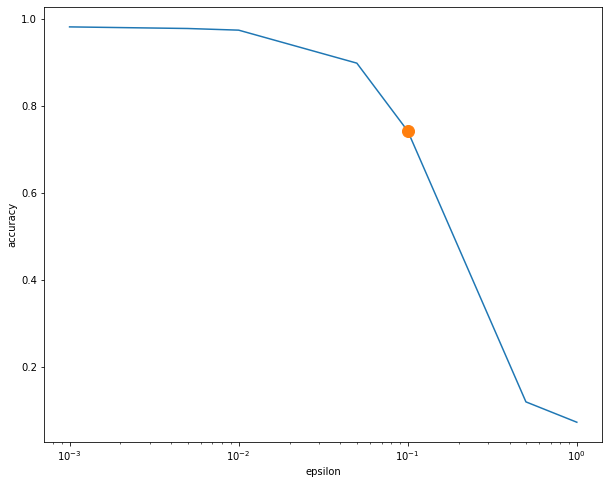

In [16]:
plt.plot(epsilons, accuracies)
plt.plot(epsilons[-3], accuracies[-3], marker="o", markersize=12)
plt.xscale("log")
plt.xlabel("epsilon")
plt.ylabel("accuracy")
plt.show()

We see that for epsilon=0.1 we have a decent accuracy decrease while this value is still not too obvious. Because of that we will use the examples for epsilon=0.1 in the following.

In [17]:
%%time
adversarialExamples = fastGradientSign(x_test, y_test, model, loss_function, epsilon=0.1)

Wall time: 3.22 s


In [18]:
acc_FGSM = accuracies[-3]
print("The accuracy of the model for these examples is: %.2f"%acc_FGSM)

The accuracy of the model for these examples is: 0.74


### 1.1.4: Visualizing the results (5 Points)

Please chose one sample for each class (for example the first when iterating the test data) and plot the (ten) adversarial examples as well as the predicted label (before and after the attack)

In [19]:
def printColumn(x, y, column, title, clipRange, axis):
    axis[0][2*column].set_title(title)
    for i in range(len(y)):
        if clipRange:
            axis[i][2*column].imshow(torch.squeeze(x[i]), vmin=0, vmax=1)
        else:
            axis[i][2*column].imshow(torch.squeeze(x[i]))
        axis[i][2*column].axis("off")
        axis[i][2*column+1].text(-0.5, 0.5, "Prediction:" + str(y[i].item()), fontsize=12)
        axis[i][2*column+1].axis("off")

In [20]:
def printImageExamples(imageSets, names, clipRanges, axis):
    # filter samples for print
    printIndices = getFirstPositionOfEachLabel(y_test, np.arange(10))
    for i, (name, images, clipRange) in enumerate(zip(names, imageSets, clipRanges)):
        xPrint = images[printIndices]
        yPrint = predict(xPrint, model)
        printColumn(xPrint, yPrint, i, name, clipRange, axis)

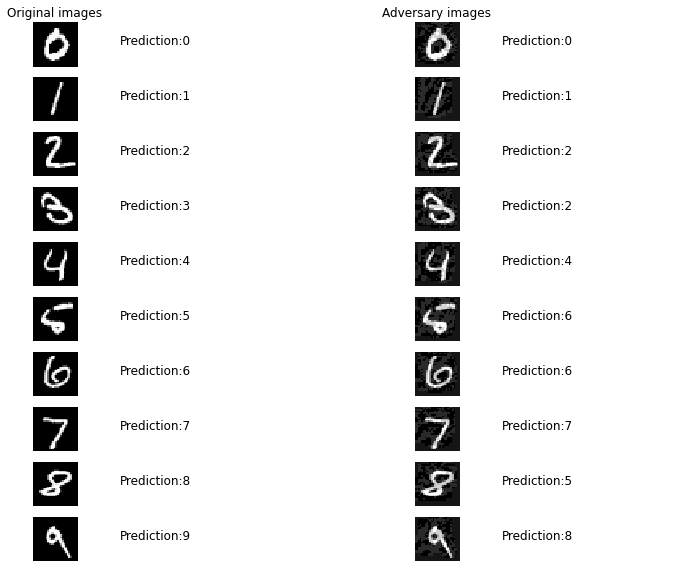

In [21]:
printImages = [x_test, adversarialExamples]
printImagesNames = ["Original images", "Adversary images"]
clipRanges = [False, False]

fig,ax = plt.subplots(nrows = 10, ncols = 4)
printImageExamples(printImages, printImagesNames, clipRanges, ax)
fig.tight_layout()
plt.show()

The above plot shows some examples of misclassifications even though a human can still easily detect the digits. However, a human is definitely also able to see that the images have been modified.

### 1.2.1: Using libraries for attacks (10 Points)
As the field of evasion attacks (in particular for DNN) is very active research field, several libraries have been published that contain attacks. We will work here with the Foolbox (https://github.com/bethgelab/foolbox) library. Please implement two other (recent, advanced) attacks of your choice using this library. 

In [22]:
import foolbox.attacks as attacks
from foolbox import PyTorchModel
from foolbox.distances import LpDistance

# change to evaluation mode to make model deterministic
model.eval()
# create model for foolbox library
foolModel = PyTorchModel(model, bounds=(0,1), device=device)
# use smaller set for foolbox pertubations to have better performance
pertub_samples = 2000
x_test_pertub = x_test[:pertub_samples]
y_test_pertub = y_test[:pertub_samples]

#### Attack 1: Spatial

For the first attack we decided to use the spatial attack which tries to rotate and translate input images to achieve a misclassification. This seemed applicable and interesting since these are basic image transformations that could also be achieved in the real world. We also chose to use its default transformation boundaries of 30 degree rotation and 3 pixel translation since these are still reasonably correctable by humans.

In [23]:
%%time
# (a) attack 1
spatialAttack = attacks.SpatialAttack()
xSpatial, _, success = spatialAttack(foolModel, torch.unsqueeze(x_test_pertub, 1), y_test_pertub)
successRate = np.count_nonzero(success.cpu().numpy()) / len(success) * 100
print("Success rate for spatial attack is", successRate, "%")

Success rate for spatial attack is 100.0 %
Wall time: 32.2 s


In [24]:
predictions = predict(x_test_pertub, model)
testAccuracy = torch.sum(predictions == y_test_pertub) / len(y_test_pertub)
print("Test accuracy of model was", testAccuracy.item() * 100, "%.")

Test accuracy of model was 97.54999876022339 %.


In [25]:
predictions = predict(torch.squeeze(xSpatial, dim=1), model)
testAccuracy = torch.sum(predictions == y_test_pertub) / len(y_test_pertub)
print("Test accuracy of model after pertubations is", testAccuracy.item() * 100, "%.")

Test accuracy of model after pertubations is 0.0 %.


#### Attack 2: Contrast

As another basic image transformation we chose the contrast reduction attack since image contrast can easily be influenced in the real world by e.g. lighting. Moreover, we decided to not limit the amount of allowed contrast reduction to investigate how radical the reduction has to be in order to achieve a misclassification.

In [26]:
%%time
# (b) attack 2
distance = LpDistance(p=2)
contrastAttack = attacks.BinarySearchContrastReductionAttack(distance=distance)
xContrast, _, success = contrastAttack(foolModel, torch.unsqueeze(x_test_pertub, 1),
                                       y_test_pertub, epsilons=None)
successRate = np.count_nonzero(success.cpu().numpy()) / len(success) * 100
print("Success rate for contrast attack is", successRate, "%")

Success rate for contrast attack is 91.60000000000001 %
Wall time: 3.95 s


In [27]:
predictions = predict(x_test_pertub, model)
testAccuracy = torch.sum(predictions == y_test_pertub) / len(y_test_pertub)
print("Test accuracy of model was", testAccuracy.item() * 100, "%.")

Test accuracy of model was 97.54999876022339 %.


In [28]:
predictions = predict(torch.squeeze(xContrast, dim=1), model)
testAccuracy = torch.sum(predictions == y_test_pertub) / len(y_test_pertub)
print("Test accuracy of model after pertubations is", testAccuracy.item() * 100, "%.")

Test accuracy of model after pertubations is 8.399999886751175 %.


### 1.2.2: Visualizing the results (20 Points)
As before, please plot the new adversarial examples. Compare all crafting techniques (FGSM, 2 methods from Foolbox).


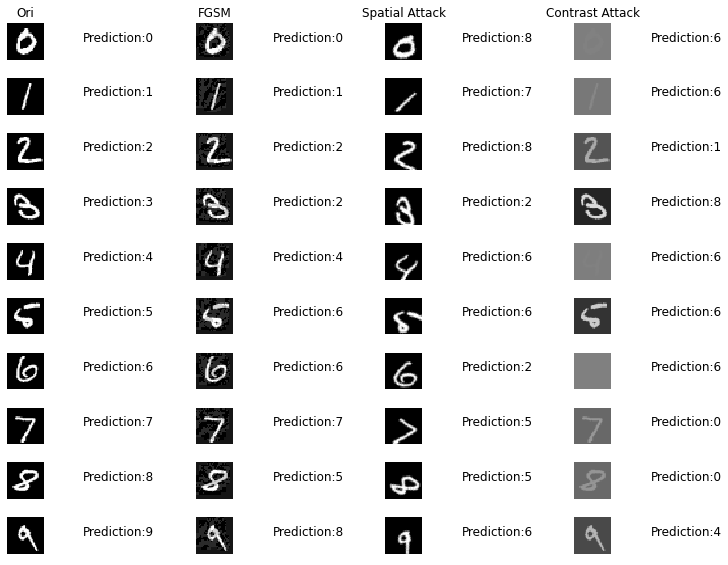

In [29]:
printImages = [x_test, adversarialExamples, torch.squeeze(xSpatial), torch.squeeze(xContrast)]
printImagesNames = ["Ori", "FGSM", "Spatial Attack", "Contrast Attack"]
clipRanges = [False, False, False, True]

fig,ax = plt.subplots(nrows = 10, ncols = 8)
printImageExamples(printImages, printImagesNames, clipRanges, ax)
fig.tight_layout()
plt.show()

In [30]:
# get input vector differences
fgsmDiff = torch.reshape(x_test - adversarialExamples, (-1, 28*28))
spatialDiff = torch.reshape(x_test[:pertub_samples] - torch.squeeze(xSpatial), (-1, 28*28))
contrastDiff = torch.reshape(x_test[:pertub_samples] - torch.squeeze(xContrast), (-1, 28*28))
# calculate norms of differences
diffs = [fgsmDiff, spatialDiff, contrastDiff]
norms = []
for diff in diffs:
    l0 = torch.norm(diff, p=0, dim=1)
    l2 = torch.norm(diff, p=2, dim=1)
    linf = torch.norm(diff, p=float('inf'), dim=1)
    norms.append([l0, l2, linf])
# get statistics about norms
meanNorms = [[torch.mean(x).item() for x in y] for y in norms]
maxNorms = [[torch.max(x).item() for x in y] for y in norms]

In [31]:
index = ["L0", "L2", "Linf"]
columns = ["FGSM", "Spatial", "Contrast"]

In [32]:
print("Mean norms")
pd.DataFrame(meanNorms, index=index, columns=columns)

Mean norms


,FGSM,Spatial,Contrast
L0,591.064575,2.430669,0.100000
L2,245.425003,9.491382,0.973819
Linf,764.791992,10.492222,0.389181


In [33]:
print("Max norms")
pd.DataFrame(maxNorms, index=index, columns=columns)

Max norms


,FGSM,Spatial,Contrast
L0,665.0,2.578770,0.1
L2,414.0,14.316476,1.0
Linf,784.0,13.703956,0.5


Which differences do you observe when comparing different attack methods? Why?   
Please write a brief summary of your findings.   
* Does the attack always succeed (the model make wrong prediction on the adversarial sample)?

* How different is the adversarial sample from the original image? (L0,L2,Linf norm)

* How about the computation cost of each attack method?

* Does the attack require white-box access to the model?


We saw that the FGSM attack with the choice of epsilon=0.1 only succeeded on roughly 24% of the samples. In contrast to that the spatial attack was always successful and the contrast attack had a 91.6% success rate. Thus, we see that the more advanced attacks from foolbox are far more sucessful.

In terms of vector norms we see in the tables above that the FGSM samples differ most from the original ones with respect to all norms. The second largest but already significantly smaller norm differences are given by the spatial attack followed by the smallest difference norms for the contrast attack. This is probably due to the fact that the simple FGSM does not preserve the valid value range $[0,1]$ since it only takes an epsilon-sized sign-gradient step. Thus, FGSM can be quite easily automatically detected.

Furthermore, the visual differences in the figure above show that FGSM only seems to add some sort of visual noise to the samples but they are still very well readable by a human. This is also true for the spatial attack since it only slightly translates or rotates the digits. For the contrast attack many digits are also still readable but the modified 0, 4 and 6 are basically plain grey images.

The computational cost of FGSM is very low due to its simplicity and thus we could also run it on all of the test set. Both of the foolbox methods take a significantly longer time which is why we only applied them to 2000 samples. From the output above we see that the spatial attack despite only using $\frac{1}{5}$ of the dataset needed about 10 times as much compuation time as FGSM. The computational time for the contrast attack was very similar to FGSM but again only using $\frac{1}{5}$ of the dataset.

Since the gradient is used in FGSM it needs whitebox access. In contrast to that the spatial attack only performs a grid search on rotations and translations and can thus work with a blackbox model. Similarly the contrast attack reduces the contrast in a binary search without any knowledge of the model gradient and thus works with a blackbox model.

We can summarize the above in the following table:

| Method | Success rate | Norm detectability | Human detectability | Speed | white-box? |
| ------ | ------------ | ------------------ | ------------------- | ----- | ---------- |
| FGSM | medium | high | low | high | yes |
| Spatial | very high | medium | low | low | no |
| Contrast | high | low | high | medium | no |

# 2. Defending an ML model

So far, we have focused on attacking an ML model. In this section, we want you to defend your model. As before concerning the attack, you can chose an example from the lecture, or experiment with any idea you have.

We do not require the defense to work perfectly - but what we want you to understand is why it works or why it does not work.

### 2.1: Implementing a defense of your choice (25 Points)
As stated before, feel free to implement a defense or mitigation of your choice. Evaluate the defense on adversarial examples. This entails at least the 1,000 examples crafted from FGSM.   
Also, you are encouraged (optional) to defend against the two other attack methods, i.e. you are free to increase this special test set (for example by >30 examples (>10 from your FGSM attack, >10 from both the two other attacks of the library)).

### Defense against FGSM

In [34]:
batch_size_train = 64
batch_size_test = 256
n_epochs = 6
learning_rate = 0.001
betas = (0.9, 0.999)

In [35]:
def adversarial_train(x, y, x_eval, y_eval, model, epochs, batch_size, loss_function, optimizer):
    clean_accuracies = []
    adv_accuracies = []
    clean_losses = []
    adv_losses = []
    
    for epoch in range(epochs):
        # take record of current performance
        clean_accuracy, clean_loss = test(x, y, model, 256, loss_function)     
        adv_accuracy, adv_loss = test(x_eval, y_eval, model, 256, loss_function)
        print("Clean Accuracy:", clean_accuracy, "Clean Loss:", clean_loss)
        print("Adv Accuracy:", adv_accuracy, "Adv Loss:", adv_loss)
        clean_accuracies.append(clean_accuracy)
        adv_accuracies.append(adv_accuracy)
        clean_losses.append(clean_loss)
        adv_losses.append(adv_loss)
        # shuffle and batch the data set
        batched = get_batched_x_y(x, y, batch_size, True)
        for xi, yi in batched:
            # add channel dimension to xi (only one grayscale channel)
            xi = torch.unsqueeze(xi, 1)
            # move data to device
            xi = xi.to(device)
            yi = yi.to(device)
            # reset previous gradients
            optimizer.zero_grad()
            # forward pass through CNN
            output = model(xi)
            # calculate current loss of CNN
            loss = loss_function(output, yi)
            # backprop
            loss.backward()
            # take optimization step
            optimizer.step()
            
            #adversarial training
            xi = fastGradientSign(xi, yi, model, loss_function, epsilon=0.1, training = True)
            xi = xi.to(device)
            yi = yi.to(device)
            optimizer.zero_grad()
            output = model(xi)
            loss = loss_function(output, yi)
            loss.backward()
            optimizer.step()
            
    return accuracies, clean_losses

In [36]:
def test(x, y, model, batch_size, loss_function):
    averageLoss = 0.0
    averageAccuracy = 0.0
    numBatches = 0
    # batch the data set
    batched = get_batched_x_y(x, y, batch_size, False)
    for xi, yi in batched:
        # add channel dimension to xi (only one grayscale channel)
        xi = torch.unsqueeze(xi, 1)
        # move data to device
        xi = xi.to(device)
        yi = yi.to(device)
        # forward pass through CNN
        output = model(xi)
        # calculate current loss of CNN
        loss = loss_function(output, yi)
        # calculate accuracy
        predicted = torch.argmax(output, 1)
        matches = yi == predicted
        accuracy = matches.sum() / batch_size
        # record all values
        averageAccuracy += accuracy.item()
        averageLoss += loss.item()
        numBatches += 1
    averageAccuracy /= numBatches
    averageLoss /= numBatches
    return averageAccuracy, averageLoss

In [37]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=betas)
accuracies, losses = adversarial_train(x_trainval, y_trainval, adversarialExamples, y_test, model, n_epochs, batch_size_train, nn.CrossEntropyLoss(), optimizer)


Clean Accuracy: 0.9811336436170213 Clean Loss: 1.478134466739411
Adv Accuracy: 0.72529296875 Adv Loss: 1.7140396177768706
Clean Accuracy: 0.9786569148936171 Clean Loss: 1.48016614000848
Adv Accuracy: 0.89296875 Adv Loss: 1.5454252660274506
Clean Accuracy: 0.9796875 Clean Loss: 1.4790856894026412
Adv Accuracy: 0.90302734375 Adv Loss: 1.534730890393257
Clean Accuracy: 0.9817320478723405 Clean Loss: 1.4769609689712524
Adv Accuracy: 0.91083984375 Adv Loss: 1.5266834288835525
Clean Accuracy: 0.9841755319148936 Clean Loss: 1.4744181379358818
Adv Accuracy: 0.921875 Adv Loss: 1.5166279166936874
Clean Accuracy: 0.9843417553191489 Clean Loss: 1.4741468576674766
Adv Accuracy: 0.92255859375 Adv Loss: 1.5154702574014665


In [38]:
acc_FGSM_defend, _= test(adversarialExamples, y_test, model, batch_size_test, nn.CrossEntropyLoss())
acc_clean, _ = test(x_test, y_test, model, batch_size_test, nn.CrossEntropyLoss())
acc_spatial, _= test(torch.squeeze(xSpatial, dim=1), y_test_pertub, model, batch_size_test, nn.CrossEntropyLoss())
acc_contrast, _= test(torch.squeeze(xContrast, dim=1), y_test_pertub, model, batch_size_test, nn.CrossEntropyLoss())

#### Results of FGSM defense

In [39]:

print('x_trainval.shape = {},  y_trainval.shape = {}'.format(x_trainval.shape, y_trainval.shape))
print('x_test.shape = {},  y_test.shape = {}'.format(x_test.shape, y_test.shape))
print('Accuracy on adversarial samples (FGSM): %.2f'%acc_FGSM)
print('Accuracy on adversarial samples (FGSM) after defense: %.2f'%acc_FGSM_defend)
print('Accuracy on clean test samples after defense: %.2f'%acc_clean)
print('Accuracy on spatial attack test samples after defense: %.2f'%acc_spatial)
print('Accuracy on contrast attack test samples after defense: %.2f'%acc_contrast)

x_trainval.shape = torch.Size([60000, 28, 28]),  y_trainval.shape = torch.Size([60000])
x_test.shape = torch.Size([10000, 28, 28]),  y_test.shape = torch.Size([10000])
Accuracy on adversarial samples (FGSM): 0.74
Accuracy on adversarial samples (FGSM) after defense: 0.92
Accuracy on clean test samples after defense: 0.96
Accuracy on spatial attack test samples after defense: 0.17
Accuracy on contrast attack test samples after defense: 0.36


### Attempt at rotation defense

In [ ]:
data_transforms = transforms.Compose([
        transforms.RandomRotation(30)
        ])

In [ ]:
x_transformed = data_transforms(x_trainval)

In [ ]:
n_epochs = 3

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=betas)
accuracies, losses = adversarial_train(x_transformed, y_trainval, adversarialExamples, y_test, model, n_epochs, batch_size_train, nn.CrossEntropyLoss(), optimizer)

Clean Accuracy: 0.9800864361702127 Clean Loss: 1.478520659182934
Adv Accuracy: 0.92099609375 Adv Loss: 1.516292667388916
Clean Accuracy: 0.982313829787234 Clean Loss: 1.4761445060689398
Adv Accuracy: 0.9197265625 Adv Loss: 1.5180575102567673
Clean Accuracy: 0.983843085106383 Clean Loss: 1.474804364874008
Adv Accuracy: 0.923828125 Adv Loss: 1.5143093109130858


In [ ]:
acc_FGSM_defend, _= test(adversarialExamples, y_test, model, batch_size_test, nn.CrossEntropyLoss())
acc_clean, _ = test(x_test, y_test, model, batch_size_test, nn.CrossEntropyLoss())
acc_spatial, _= test(torch.squeeze(xSpatial, dim=1), y_test_pertub, model, batch_size_test, nn.CrossEntropyLoss())
acc_contrast, _= test(torch.squeeze(xContrast, dim=1), y_test_pertub, model, batch_size_test, nn.CrossEntropyLoss())

#### Results of defense against rotation attack

In [ ]:

print('x_trainval.shape = {},  y_trainval.shape = {}'.format(x_trainval.shape, y_trainval.shape))
print('x_test.shape = {},  y_test.shape = {}'.format(x_test.shape, y_test.shape))
print('Accuracy on adversarial samples (FGSM): %.2f'%acc_FGSM)
print('Accuracy on adversarial samples (FGSM) after defense: %.2f'%acc_FGSM_defend)
print('Accuracy on clean test samples after defense: %.2f'%acc_clean)
print('Accuracy on spatial attack test samples after defense: %.2f'%acc_spatial)
print('Accuracy on contrast attack test samples after defense: %.2f'%acc_contrast)

x_trainval.shape = torch.Size([60000, 28, 28]),  y_trainval.shape = torch.Size([60000])
x_test.shape = torch.Size([10000, 28, 28]),  y_test.shape = torch.Size([10000])
Accuracy on adversarial samples (FGSM): 0.74
Accuracy on adversarial samples (FGSM) after defense: 0.92
Accuracy on clean test samples after defense: 0.96
Accuracy on spatial attack test samples after defense: 0.12
Accuracy on contrast attack test samples after defense: 0.45


### Contrast defense

In [67]:
contrast_samples = 2000
x_train_pertub = x_trainval[:contrast_samples]
y_train_pertub = y_trainval[:contrast_samples]

In [64]:
contrast_train, contrast_, success = contrastAttack(foolModel, torch.unsqueeze(x_train_pertub, 1),
                                       y_train_pertub, epsilons=None)
contrast_train = torch.squeeze(contrast_train)

In [51]:
n_epochs = 3

In [68]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=betas)
accuracies, losses = adversarial_train(contrast_train, y_train_pertub, adversarialExamples, y_test, model, n_epochs, batch_size_train, nn.CrossEntropyLoss(), optimizer)

Clean Accuracy: 0.08203125 Clean Loss: 1.9937036335468292
Adv Accuracy: 0.92099609375 Adv Loss: 1.516292667388916
Clean Accuracy: 0.9296875 Clean Loss: 1.5415918678045273
Adv Accuracy: 0.83916015625 Adv Loss: 1.5984358221292496
Clean Accuracy: 0.9443359375 Clean Loss: 1.5333095043897629
Adv Accuracy: 0.77080078125 Adv Loss: 1.668141108751297


In [69]:
acc_FGSM_defend, _= test(adversarialExamples, y_test, model, batch_size_test, nn.CrossEntropyLoss())
acc_clean, _ = test(x_test, y_test, model, batch_size_test, nn.CrossEntropyLoss())
acc_spatial, _= test(torch.squeeze(xSpatial, dim=1), y_test_pertub, model, batch_size_test, nn.CrossEntropyLoss())
acc_contrast, _= test(torch.squeeze(xContrast, dim=1), y_test_pertub, model, batch_size_test, nn.CrossEntropyLoss())

#### Results of contrast defense

In [70]:
print('x_trainval.shape = {},  y_trainval.shape = {}'.format(x_trainval.shape, y_trainval.shape))
print('x_test.shape = {},  y_test.shape = {}'.format(x_test.shape, y_test.shape))
print('Accuracy on adversarial samples (FGSM): %.2f'%acc_FGSM)
print('Accuracy on adversarial samples (FGSM) after defense: %.2f'%acc_FGSM_defend)
print('Accuracy on clean test samples after defense: %.2f'%acc_clean)
print('Accuracy on spatial attack test samples after defense: %.2f'%acc_spatial)
print('Accuracy on contrast attack test samples after defense: %.2f'%acc_contrast)

x_trainval.shape = torch.Size([60000, 28, 28]),  y_trainval.shape = torch.Size([60000])
x_test.shape = torch.Size([10000, 28, 28]),  y_test.shape = torch.Size([10000])
Accuracy on adversarial samples (FGSM): 0.74
Accuracy on adversarial samples (FGSM) after defense: 0.71
Accuracy on clean test samples after defense: 0.81
Accuracy on spatial attack test samples after defense: 0.14
Accuracy on contrast attack test samples after defense: 0.60


### 2.2: Conclusions (15 Points)
Please interpret the results of your defense here. 

* What did you try to make the classifier more robust against FGSM? 
* Why did it work? 
* Is the classifier now robust against FGSM?  
* ...

Feel free to state any interesting finding you encountered during this project.

To make the clasifier more robust against FGSM, we used adversarial training.  We continue training on the loaded model from the last assignment. In our implementation, we generate adversarial samples for each batch iteration in training using the same FGSM function we defined previously, and feed them to the model simultaneously with the original samples. 

This method worked because the model is learning from adversarial samples and because of this is able to accurately classify the samples from the altered dataset. We are essentally doing an outer minimzation on the inner maximization of the loss done by the FGSM method.

Not only is the classifier robust against this FGSM attack (93% accuracy on FGSM adversarial test set), but it also maintained most of the accuracy when testing with the original dataset (96% accuracy on original test set) although with a tradeoff of about 2% accuracy loss from our original model. Because of this defense, the model recovered 19% accuracy (from 74% to 93%) on the adversarial FGSM set. In addition to this, we could also see that through the first adversarial training the model obtained better accuracy on the spatial and contrast test sets previously created: 0 to 17% on spatial samples and 8.4% to 36% on accuracy samples.

Following the defense against FGSM, we tried defending against spatial attacks by continuing to train the model with a transformated training set using the pytorch transforms module. We applied random rotations within 30 degrees for each image in the dataset because this is the same range of degree that the foolbox library uses. 
However, after training for 3 epochs the model's accuracy worsened on predicting the spatial samples. One possible reason for this is that plain CNNs are generally rotation dependent because of their structure. This makes it difficult to train them for rotation invariance. Also, the attack also performs translations besides rotations which was not exploited in this adversarial training. 

After our attempt at defending against spatial attacks, we tried training again 3 epochs on the adversarial trained model with samples of varying contrasts. Through this training we improved greatly accuracy on contrast samples (36% to 60%). However, accuracy on the FGSM and clean samples dropped significantly: 92% to 71% on FGSM and 96% to 81% on clean samples. This suggests that we should continue training on adversarial and clean samples while introducing contrasted samples too so that the model can generalize predictions for those cases.